In this example, we will compare stop loss orders and trailing stop orders for different stop values.

In [1]:
import vectorbt as vbt

In [2]:
import numpy as np
import pandas as pd
import itertools
import yfinance as yf

In [3]:
# Define your params here
INVESTMENT = 100 # in $
COMMISSION = 0.0025 # in %
SLIPPAGE = 0.0025 # in %
STOPS = np.arange(0, 0.3, 0.0001)
ASSET_NAME = 'MSFT'

In [4]:
# Download data
ticker = yf.Ticker(ASSET_NAME)
df = ticker.history(period="max")
df = df.astype(np.float64)

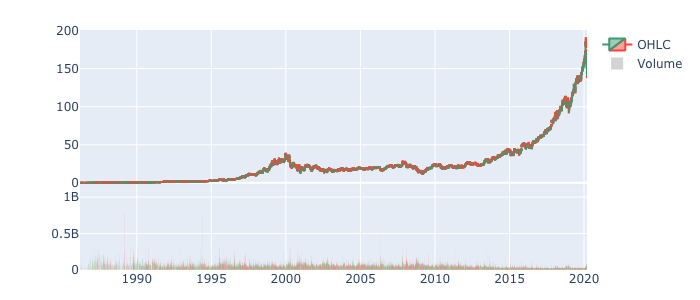

In [5]:
df.vbt.ohlcv.plot().show_png()

In [6]:
# Define your basic strategy here (must be of shape (n, 1))
FAST_WINDOW = 30
SLOW_WINDOW = 80

dmac = vbt.DMAC(df['Open'], FAST_WINDOW, SLOW_WINDOW)
dmac_entries, dmac_exits = dmac.crossover_signals()

print(dmac_entries.shape, dmac_exits.shape)

(8571,) (8571,)


In [7]:
# Calculate exits for each stop in STOPS
stoploss_exits = dmac_entries.vbt.signals.stoploss_exits(df['Open'], STOPS)
trailstop_exits = dmac_entries.vbt.signals.trailstop_exits(df['Open'], STOPS)

print(stoploss_exits.shape, trailstop_exits.shape)

(8571, 3000) (8571, 3000)


In [8]:
# Combine strategy exits and stop loss exits
stoploss_exits = dmac_exits.vbt.signals.OR(stoploss_exits)
trailstop_exits = dmac_exits.vbt.signals.OR(trailstop_exits)

print(stoploss_exits.shape, trailstop_exits.shape)

(8571, 3000) (8571, 3000)


In [9]:
stoploss_portfolio = vbt.Portfolio.from_signals(
    df['Open'], dmac_entries, stoploss_exits, investment=INVESTMENT, commission=COMMISSION)
trailstop_portfolio = vbt.Portfolio.from_signals(
    df['Open'], dmac_entries, trailstop_exits, investment=INVESTMENT, commission=COMMISSION)

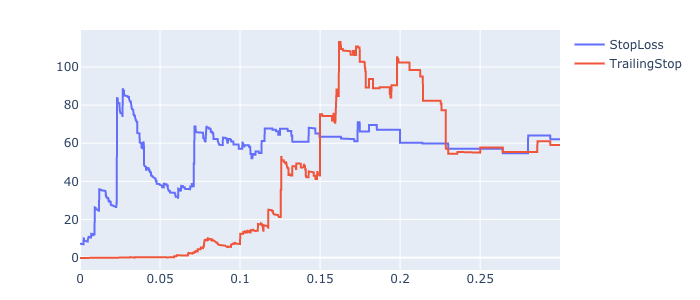

In [10]:
pd.DataFrame({
    'StopLoss': stoploss_portfolio.total_return,
    'TrailingStop': trailstop_portfolio.total_return
}).vbt.scatter().show_png()

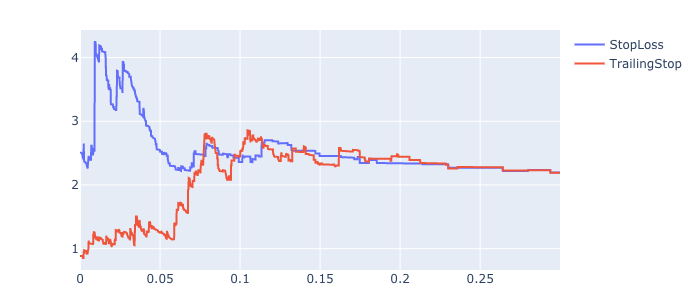

In [11]:
pd.DataFrame({
    'StopLoss': stoploss_portfolio.profit_factor,
    'TrailingStop': trailstop_portfolio.profit_factor
}).vbt.scatter().show_png()